In [6]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import re
import math

%matplotlib inline

In [7]:

def plot_images(data, layout='row', cols=2, figsize=(20, 12)):
    '''
    Utility function for plotting images
    :param data [(ndarray, string)]: List of data to display, [(image, title)]
    :param layout (string): Layout, row-wise or column-wise
    :param cols (number): Number of columns per row
    :param figsize (number, number): Tuple indicating figure size
    '''
    rows = math.ceil(len(data) / cols)
    f, ax = plt.subplots(figsize=figsize)
    if layout == 'row':
        for idx, d in enumerate(data):
            img, title = d

            plt.subplot(rows, cols, idx+1)
            plt.title(title, fontsize=20)
            plt.axis('off')
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
                
            elif len(img.shape) == 3:
                plt.imshow(img)
                
    elif layout == 'col':
        counter = 0
        for r in range(rows):
            for c in range(cols):
                img, title = data[r + rows*c]
                nb_channels = len(img.shape)
                
                plt.subplot(rows, cols, counter+1)
                plt.title(title, fontsize=20)
                plt.axis('off')
                if len(img.shape) == 2:
                    plt.imshow(img, cmap='gray')
                
                elif len(img.shape) == 3:
                    plt.imshow(img)
              
                counter += 1

    return ax

In [8]:
IMG_SHAPE = (661,878)

In [13]:
import numpy as np
import cv2
import math

def polyfit_sliding_window(binary, pipe_width_px=30, visualise=True, diagnostics=False):
    '''
    Detect pipe lines in a thresholded binary image using the sliding window technique
    :param binary (ndarray): Thresholded binary image
    :param pipe_width_px (int): Average pipe width (in px) for the image, computed empirically
    :param visualise (boolean): Boolean flag for visualisation
    :param diagnositics (boolean): Boolean flag for logging
    '''
    # Sanity check
    if binary.max() <= 0:
        return np.array([])

    # Create an output image by stacking the binary image three times
    out = np.dstack((binary, binary, binary)) * 255
    # Find the first non-zero pixel in the image as the starting point
    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    start_x = nonzerox[0]
    start_y = nonzeroy[0]
    nb_windows = 20  # number of sliding windows
    margin = 50  # width of the windows +/- margin
    window_height = int(binary.shape[0] / nb_windows)  # height of the windows
    # Current positions to be updated for each window
    x_current = start_x
    y_current = start_y
    # Empty lists to receive pipe pixel indices and angles
    pipe_inds = []
    angles = []
    for window in range(nb_windows):
        # Identify window boundaries in x and y
        win_y_low = binary.shape[0] - (1 + window) * window_height
        win_y_high = binary.shape[0] - window * window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin
        # Draw window for visualisation
        if visualise:
            cv2.rectangle(out, (win_x_low, win_y_low), (win_x_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_x_low) & (nonzerox <= win_x_high)).nonzero()[0]
        pipe_inds.append(good_inds)
        # If you found enough pixels, recenter the next window on their mean position
        if len(good_inds) > 0:
            x_current = int(np.mean(nonzerox[good_inds]))
            y_current = int(np.mean(nonzeroy[good_inds]))

    pipe_inds = np.concatenate(pipe_inds)
    # Extract pixel positions for the pipe
    pipe_x = nonzerox[pipe_inds]
    pipe_y = nonzeroy[pipe_inds]

    # Connect the detected pixels to form a line representing the pipe
    pipe_line = np.column_stack((pipe_x, pipe_y))
    pipe_line = np.array([pipe_line])

    # Draw the detected pipe line
    cv2.polylines(out, np.int32(pipe_line), isClosed=False, color=(0, 0, 255), thickness=2)
    if visualise:
        plot_images([(binary, 'Binary'), (out, 'Out')])

    return pipe_line, angles

(array([[[ 48, 837],
         [ 49, 837],
         [ 50, 837],
         ...,
         [ 50, 221],
         [ 52, 221],
         [ 53, 221]]], dtype=int64),
 [])

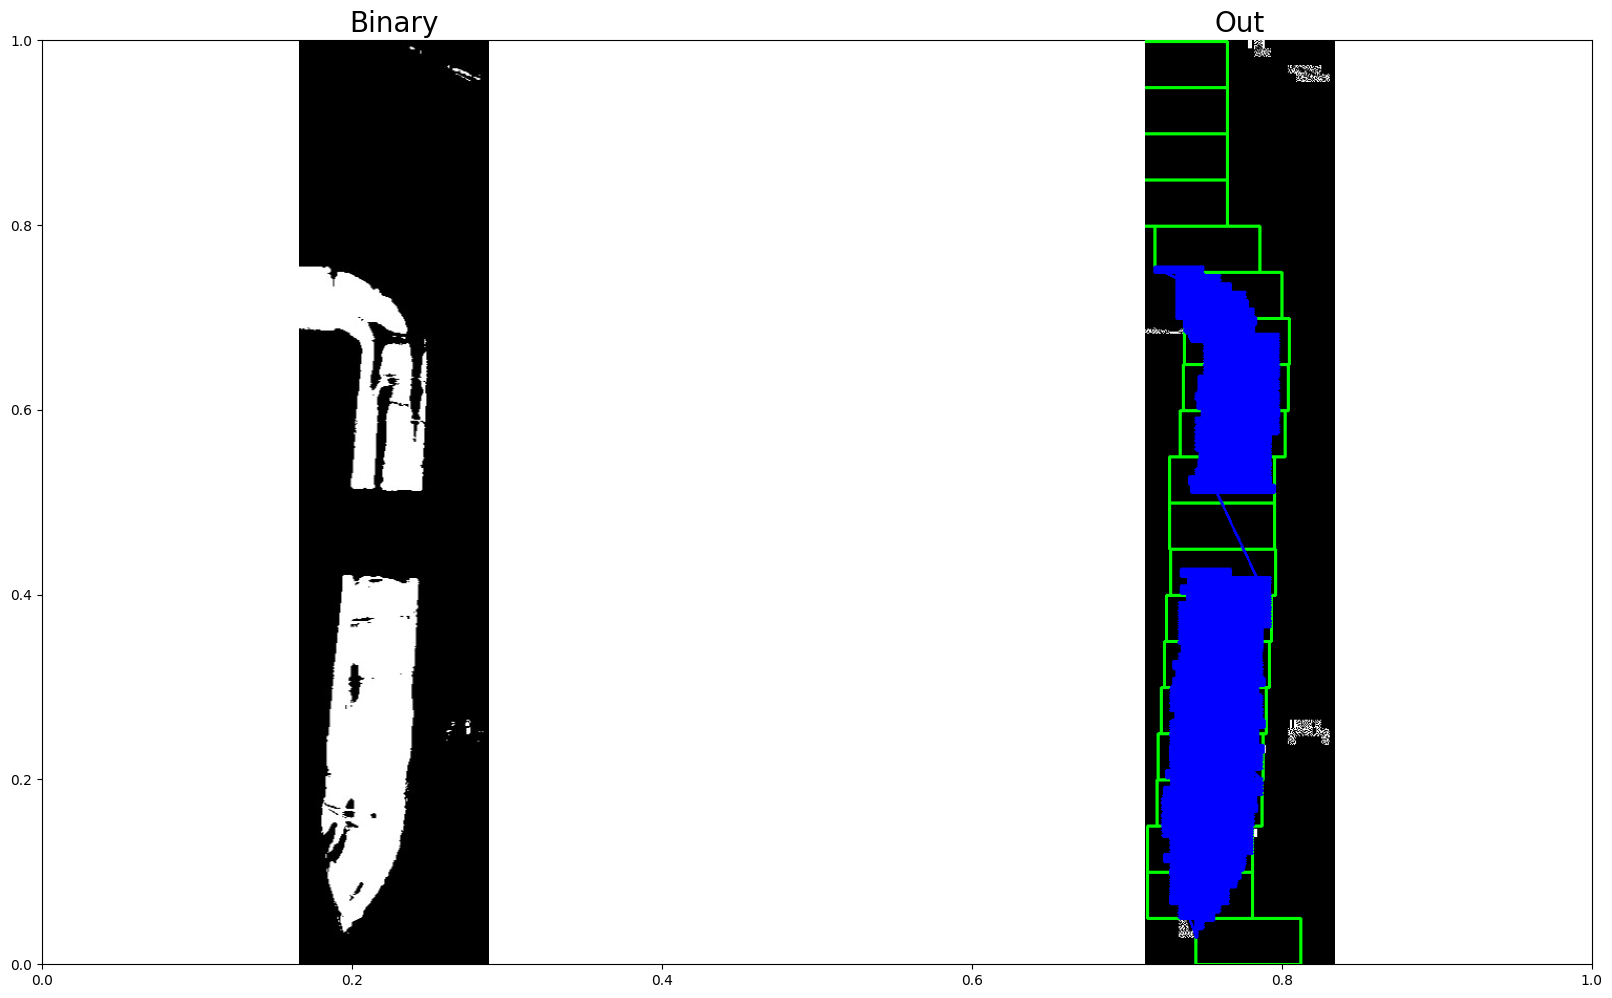

In [14]:
image = cv2.imread("binary_output_1.jpg",0)
polyfit_sliding_window(image)

In [50]:
import numpy as np
import cv2
import math

def polyfit_sliding_window(binary, pipe_width_px=30, visualise=True, diagnostics=False):
    '''
    Detect pipe lines in a thresholded binary image using the sliding window technique
    :param binary (ndarray): Thresholded binary image
    :param pipe_width_px (int): Average pipe width (in px) for the image, computed empirically
    :param visualise (boolean): Boolean flag for visualisation
    :param diagnositics (boolean): Boolean flag for logging
    '''
    # Sanity check
    if binary.max() <= 0:
        return np.array([])
    
    # Create an output image by stacking the binary image three times
    out = np.dstack((binary, binary, binary)) * 255
    
    # Find the first non-zero pixel in the image as the starting point
    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    start_x = nonzerox[0]
    start_y = nonzeroy[0]
    
    nb_windows = 20  # number of sliding windows
    margin = 55  # width of the windows +/- margin
    window_height = int(binary.shape[0] / nb_windows)  # height of the windows
    
    # Current positions to be updated for each window
    x_current = start_x
    y_current = start_y
    
    # Empty lists to receive pipe pixel indices and angles
    pipe_inds = []
    angles = []
    
    for window in range(nb_windows):
        # Identify window boundaries in x and y
        win_y_low = binary.shape[0] - (1 + window) * window_height
        win_y_high = binary.shape[0] - window * window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin
        
        # Draw window for visualisation
        if visualise:
            cv2.rectangle(out, (win_x_low, win_y_low), (win_x_high, win_y_high), (0, 255, 0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_x_low) & (nonzerox <= win_x_high)).nonzero()[0]
        pipe_inds.append(good_inds)
        
        # Apply Hough Line Transform on the window
        window_binary = np.zeros_like(binary)
        window_binary[win_y_low:win_y_high, win_x_low:win_x_high] = binary[win_y_low:win_y_high, win_x_low:win_x_high]
        # windows_binary_canny = cv2.Canny(window_binary,100,200)
        hough_lines = cv2.HoughLines(window_binary, rho=1, theta=np.pi/180, threshold=10)
        
    if hough_lines is not None:
        for line in hough_lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            # Clip the line segment to the window boundaries
            x1 = max(win_x_low, min(win_x_high, x1))
            y1 = max(win_y_low, min(win_y_high, y1))
            x2 = max(win_x_low, min(win_x_high, x2))
            y2 = max(win_y_low, min(win_y_high, y2))

            cv2.line(out, (x1, y1), (x2, y2), (255, 0,0), 3)
            angle = theta
            angles.append(angle)
        
        # If you found enough pixels, recenter the next window on their mean position
        if len(good_inds) > 0:
            x_current = int(np.mean(nonzerox[good_inds]))
            y_current = int(np.mean(nonzeroy[good_inds]))
    
    pipe_inds = np.concatenate(pipe_inds)
    
    # Extract pixel positions for the pipe
    pipe_x = nonzerox[pipe_inds]
    pipe_y = nonzeroy[pipe_inds]
    
    # Connect the detected pixels to form a line representing the pipe
    pipe_line = np.column_stack((pipe_x, pipe_y))
    pipe_line = np.array([pipe_line])
    
    # Draw the detected pipe line
    # cv2.polylines(out, np.int32(pipe_line), isClosed=False, color=(0, 0, 255), thickness=2)
    
    if visualise:
        plot_images([(binary, 'Binary'), (out, 'Out')])
    
    return pipe_line, anglesimport numpy as np
import cv2
import math

def polyfit_sliding_window(binary, pipe_width_px=30, visualise=True, diagnostics=False):
    '''
    Detect pipe lines in a thresholded binary image using the sliding window technique
    :param binary (ndarray): Thresholded binary image
    :param pipe_width_px (int): Average pipe width (in px) for the image, computed empirically
    :param visualise (boolean): Boolean flag for visualisation
    :param diagnositics (boolean): Boolean flag for logging
    '''
    # Sanity check
    if binary.max() <= 0:
        return np.array([])
    
    # Create an output image by stacking the binary image three times
    out = np.dstack((binary, binary, binary)) * 255
    
    # Find the first non-zero pixel in the image as the starting point
    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    start_x = nonzerox[0]
    start_y = nonzeroy[0]
    
    nb_windows = 20  # number of sliding windows
    margin = 55  # width of the windows +/- margin
    window_height = int(binary.shape[0] / nb_windows)  # height of the windows
    
    # Current positions to be updated for each window
    x_current = start_x
    y_current = start_y
    
    # Empty lists to receive pipe pixel indices and angles
    pipe_inds = []
    angles = []
    
    for window in range(nb_windows):
        # Identify window boundaries in x and y
        win_y_low = binary.shape[0] - (1 + window) * window_height
        win_y_high = binary.shape[0] - window * window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin
        
        # Draw window for visualisation
        if visualise:
            cv2.rectangle(out, (win_x_low, win_y_low), (win_x_high, win_y_high), (0, 255, 0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_x_low) & (nonzerox <= win_x_high)).nonzero()[0]
        pipe_inds.append(good_inds)
        
        # Apply Hough Line Transform on the window
        window_binary = np.zeros_like(binary)
        window_binary[win_y_low:win_y_high, win_x_low:win_x_high] = binary[win_y_low:win_y_high, win_x_low:win_x_high]
        # windows_binary_canny = cv2.Canny(window_binary,100,200)
        hough_lines = cv2.HoughLines(window_binary, rho=1, theta=np.pi/180, threshold=10)
        
    if hough_lines is not None:
        for line in hough_lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            # Clip the line segment to the window boundaries
            x1 = max(win_x_low, min(win_x_high, x1))
            y1 = max(win_y_low, min(win_y_high, y1))
            x2 = max(win_x_low, min(win_x_high, x2))
            y2 = max(win_y_low, min(win_y_high, y2))

            cv2.line(out, (x1, y1), (x2, y2), (255, 0,0), 3)
            angle = theta
            angles.append(angle)
        
        # If you found enough pixels, recenter the next window on their mean position
        if len(good_inds) > 0:
            x_current = int(np.mean(nonzerox[good_inds]))
            y_current = int(np.mean(nonzeroy[good_inds]))
    
    pipe_inds = np.concatenate(pipe_inds)
    
    # Extract pixel positions for the pipe
    pipe_x = nonzerox[pipe_inds]
    pipe_y = nonzeroy[pipe_inds]
    
    # Connect the detected pixels to form a line representing the pipe
    pipe_line = np.column_stack((pipe_x, pipe_y))
    pipe_line = np.array([pipe_line])
    
    # Draw the detected pipe line
    # cv2.polylines(out, np.int32(pipe_line), isClosed=False, color=(0, 0, 255), thickness=2)
    
    if visualise:
        plot_images([(binary, 'Binary'), (out, 'Out')])
    
    return pipe_line, angles

SyntaxError: invalid syntax (2858858242.py, line 103)

(array([[[ 43, 837],
         [ 44, 837],
         [ 45, 837],
         ...,
         [150,  39],
         [151,  39],
         [153,  39]]], dtype=int64),
 [2.0769417,
  2.1118484,
  2.146755,
  2.042035,
  2.0943952,
  2.1642082,
  2.0071287,
  2.0594885,
  2.1293018,
  2.1816616,
  2.024582,
  2.0594885,
  2.1816616,
  2.1991148,
  2.2165682,
  2.2340214,
  1.9547688,
  1.9896753,
  1.9896753,
  2.2863812,
  1.9547688,
  2.1991148,
  2.2165682,
  2.2340214,
  2.2514746,
  2.268928,
  2.1642082,
  2.1293018,
  2.146755,
  1.9198622,
  1.9373155,
  2.1118484,
  2.3038347,
  1.9373155,
  2.268928,
  1.850049,
  1.8849555,
  1.9024088,
  1.9198622,
  2.338741,
  2.3561945,
  2.3561945,
  2.3561945,
  1.7802358,
  1.8325957,
  1.9024088,
  1.9198622,
  2.3212879,
  2.3561945,
  2.3561945,
  2.3736477,
  1.6406095,
  1.6580628,
  1.6755161,
  1.7976891,
  1.8151424,
  1.8675023,
  1.8849555,
  1.8849555,
  2.1642082,
  2.3038347,
  2.3038347,
  2.6703537,
  2.687807,
  2.75762,
  0.191986

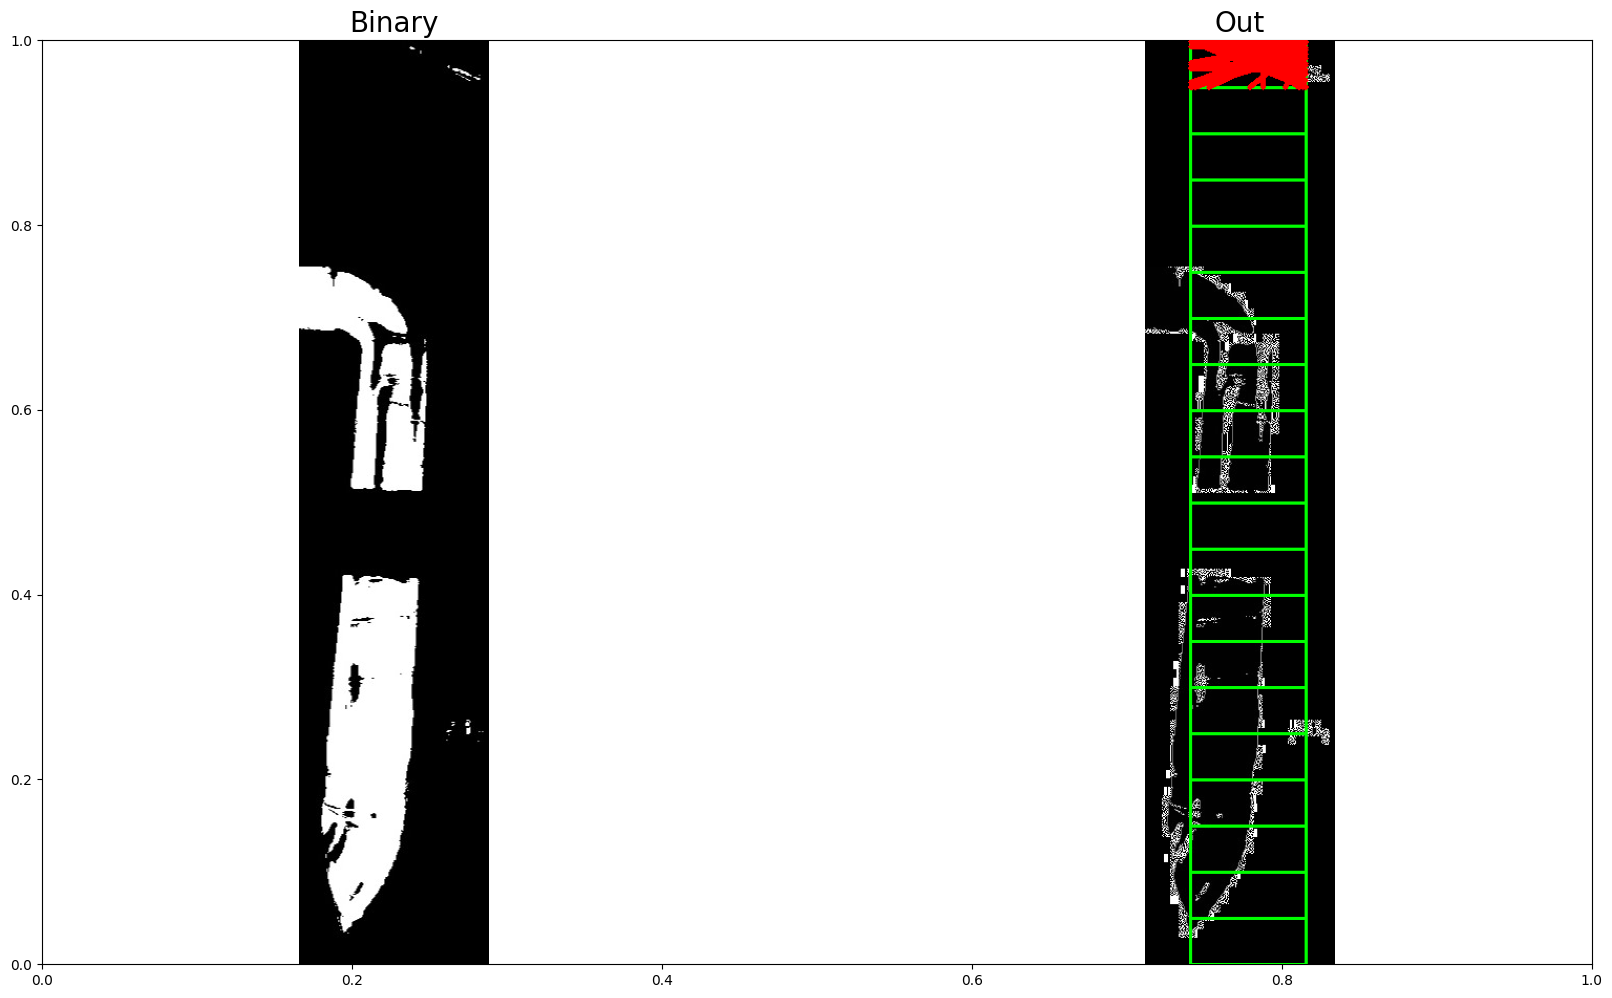

In [51]:
image = cv2.imread("binary_output_1.jpg",0)
polyfit_sliding_window(image)

In [60]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    for ax, (image, title) in zip(axes, images):
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis("off")
    plt.show()

def polyfit_sliding_window(binary, pipe_width_px=30, visualise=True, diagnostics=False):
    if binary.max() <= 0:
        return np.array([])
    
    out = np.dstack((binary, binary, binary)) * 255
    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    if len(nonzerox) == 0:
        return np.array([])

    start_x = nonzerox[len(nonzerox)//2]  # more robust initial x
    start_y = nonzeroy[len(nonzeroy)//2]  # more robust initial y

    nb_windows = 20
    margin = 55
    window_height = int(binary.shape[0] / nb_windows)

    x_current = start_x
    y_current = start_y

    pipe_inds = []

    for window in range(nb_windows):
        win_y_low = binary.shape[0] - (window + 1) * window_height
        win_y_high = binary.shape[0] - window * window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin
        
        if visualise:
            cv2.rectangle(out, (win_x_low, win_y_low), (win_x_high, win_y_high), (0, 255, 0), 2)
        
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                     (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
        pipe_inds.append(good_inds)

        window_binary = np.zeros_like(binary)
        window_binary[win_y_low:win_y_high, win_x_low:win_x_high] = binary[win_y_low:win_y_high, win_x_low:win_x_high]
        hough_lines = cv2.HoughLines(window_binary, 1, np.pi/180, threshold=70)
        
        # Process detected lines
        if hough_lines is not None:
            for line in hough_lines:
                rho, theta = line[0]
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                
                x1 = max(win_x_low, min(win_x_high, x1))
                y1 = max(win_y_low, min(win_y_high, y1))
                x2 = max(win_x_low, min(win_x_high, x2))
                y2 = max(win_y_low, min(win_y_high, y2))
                
                cv2.line(out, (x1, y1), (x2, y2), (255, 0, 0), 1)

        if len(good_inds) > 0:
            x_current = int(np.mean(nonzerox[good_inds]))
            y_current = int(np.mean(nonzeroy[good_inds]))

    pipe_inds = np.concatenate(pipe_inds)
    pipe_x = nonzerox[pipe_inds]
    pipe_y = nonzeroy[pipe_inds]
    pipe_line = np.column_stack((pipe_x, pipe_y))

    if visualise:
        plot_images([(binary, 'Binary'), (out, 'Detected Pipes')])

    return pipe_line



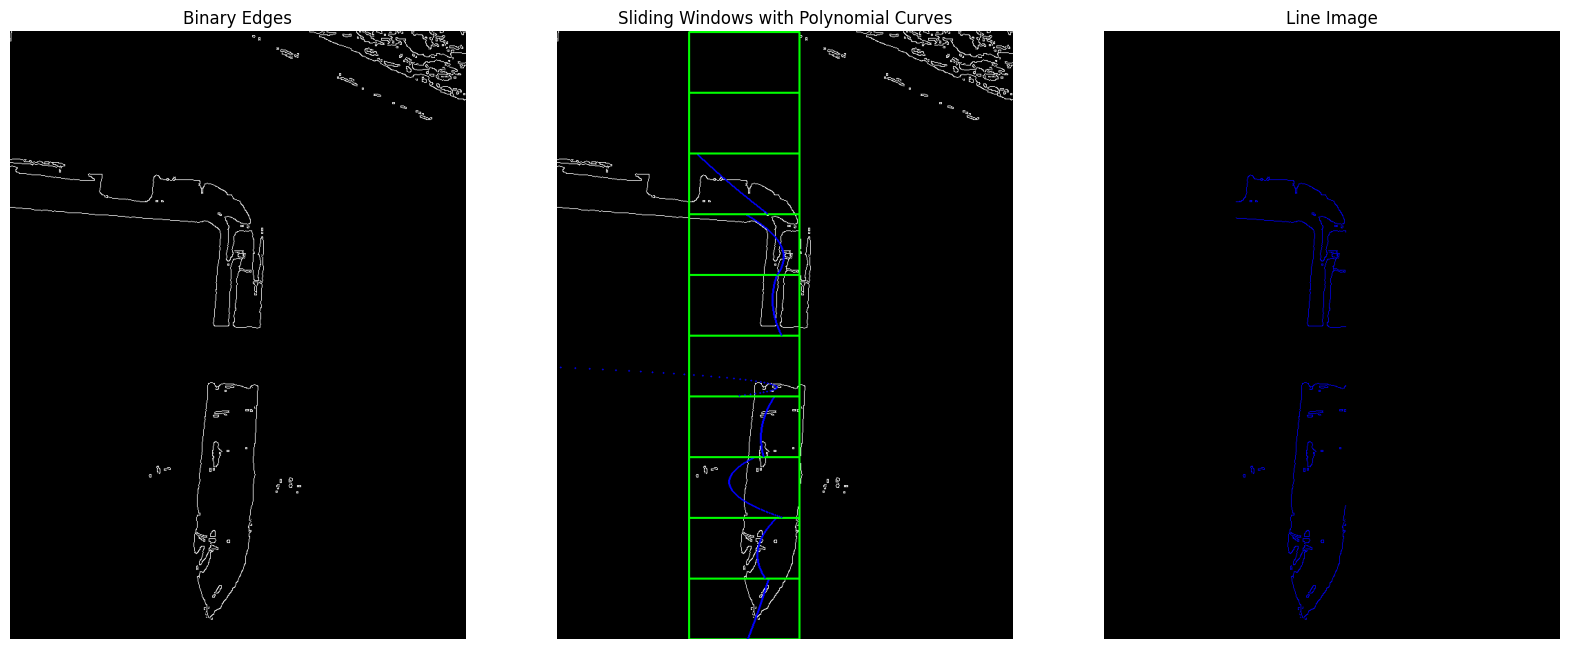

In [170]:
# Example usage
binary_image = cv2.imread('binary_output.jpg', 0)  # Update this path
detected_lines = polyfit_sliding_window(binary_image, visualise=True)

In [135]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    for ax, (image, title) in zip(axes, images):
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis("off")
    plt.show()

def polyfit_sliding_window(binary, pipe_width_px=30, visualise=True, diagnostics=False):
    if binary is None or binary.max() == 0:
        return np.array([])
    
    # binary = cv2.GaussianBlur(binary, (5, 5), 0) 
    edges = cv2.Canny(binary, 50, 150) 

    binary = edges
    out = np.dstack((binary, binary, binary))
    
    histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 10
    window_height = int(binary.shape[0]/nwindows)
    margin = 70
    minpix = 10 

    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    left_lane_inds = []

    current = leftx_base
    for window in range(nwindows):
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height

        win_x_low = current - margin
        win_x_high = current + margin

        if visualise:
            cv2.rectangle(out, (win_x_low, win_y_low), (win_x_high, win_y_high), (0,255,0), 2)

        good_inds = ((nonzerox >= win_x_low) & (nonzerox < win_x_high) & 
                     (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

        if len(good_inds) > minpix:
            current = int(np.mean(nonzerox[good_inds]))

        left_lane_inds.append(good_inds)

    left_lane_inds = np.concatenate(left_lane_inds)
    line_image = np.zeros_like(out)

    for idx in left_lane_inds:
        line_image[nonzeroy[idx], nonzerox[idx]] = [255, 0, 0]

    if visualise:
        plot_images([(binary, 'Binary Edges'), (out, 'Sliding Windows'), (line_image, 'Line Image')])

    return line_image

# Path to your image
# path = 'path_to_your_image.jpg'
# binary_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
# if binary_image is None:
#     print('Error loading image')
# else:
#     processed_image = polyfit_sliding_window(binary_image, visualise=True)

In [134]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_images(images, titles):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

def find_base_position(binary):
    """ Function to find the base position for sliding windows based on maximum histogram peak """
    histogram = np.sum(binary[binary.shape[0]//2:], axis=0)
    return np.argmax(histogram)

def polyfit_sliding_window(binary, visualise=True):
    """ Detects lines using a sliding window approach and adapts to curves """
    if binary is None or binary.max() == 0:
        return np.array([])  # Check if the image is non-empty

    # Preprocessing to enhance edges
    binary = cv2.GaussianBlur(binary, (5, 5), 0)
    edges = cv2.Canny(binary, 50, 150)

    binary = edges
    height, width = binary.shape
    out_img = np.dstack((binary, binary, binary)) * 255  # For visualization

    base_x = find_base_position(binary)

    # Sliding window parameters
    nwindows = 10
    window_height = height // nwindows
    margin = 50  # Width of the window margin
    minpix = 100  # Minimum number of pixels found to recenter window4

    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    lane_inds = []

    current_x = base_x
    # Iterate through windows from bottom to top
    for window in range(nwindows):
        win_y_low = height - (window+1)*window_height
        win_y_high = height - window*window_height

        win_x_low = max(0, current_x - margin)
        win_x_high = min(width, current_x + margin)

        if visualise:
            cv2.rectangle(out_img, (win_x_low, win_y_low), (win_x_high, win_y_high), (0, 255, 0), 2)

        window_mask = (nonzerox >= win_x_low) & (nonzerox < win_x_high) & \
                      (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
        good_inds = window_mask.nonzero()[0]

        if len(good_inds) > minpix:
            current_x = np.int32(np.mean(nonzerox[good_inds]))  # Recenter next window
            
        lane_inds.append(good_inds)

    lane_inds = np.concatenate(lane_inds)
    line_image = np.zeros_like(out_img, dtype=np.uint8)
    line_image[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]

    if visualise:
        plot_images([binary, out_img, line_image], ['Binary Edges', 'Sliding Windows', 'Detected Line'])

    return line_image

# Load the image
path = 'path_to_your_image.jpg'
binary_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
if binary_image is None:
    print('Error loading image')
else:
    processed_image = polyfit_sliding_window(binary_image, visualise=True)

Error loading image


In [153]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    for ax, (image, title) in zip(axes, images):
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis("off")
    plt.show()

def polyfit_sliding_window(binary, pipe_width_px=30, visualise=True, diagnostics=False):
    if binary is None or binary.max() == 0:
        return np.array([])
    
    binary = cv2.GaussianBlur(binary, (5, 5), 0)
    edges = cv2.Canny(binary, 50, 150)

    binary = edges
    out = np.dstack((binary, binary, binary))
    
    histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 10
    window_height = int(binary.shape[0]/nwindows)
    margin = 80
    minpix = 80  

    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    left_lane_inds = []

    current = leftx_base
    for window in range(nwindows):
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height

        win_x_low = current - margin
        win_x_high = current + margin
        
        if visualise:
            cv2.rectangle(out, (win_x_low, win_y_low), (win_x_high, win_y_high), (0,255,0), 2)
        
        # Apply the Standard Hough Line Transform within each window
        window_img = binary[win_y_low:win_y_high, win_x_low:win_x_high]
        lines = cv2.HoughLines(window_img, 1, np.pi/180, threshold=60)
        if lines is not None:
            for rho_theta in lines:
                rho, theta = rho_theta[0]
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                x1 = int(x0 + 1000 * (-b)) + win_x_low
                y1 = int(y0 + 1000 * (a)) + win_y_low
                x2 = int(x0 - 1000 * (-b)) + win_x_low
                y2 = int(y0 - 1000 * (a)) + win_y_low
                cv2.line(out, (x1, y1), (x2, y2), (255, 0, 0), 2)

        good_inds = ((nonzerox >= win_x_low) & (nonzerox < win_x_high) & 
                     (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

        if len(good_inds) > minpix:
            current = int(np.mean(nonzerox[good_inds]))

        left_lane_inds.append(good_inds)

    left_lane_inds = np.concatenate(left_lane_inds)
    line_image = np.zeros_like(out)

    for idx in left_lane_inds:
        line_image[nonzeroy[idx], nonzerox[idx]] = [255, 0, 0]

    if visualise:
        plot_images([(binary, 'Binary Edges'), (out, 'Sliding Windows with Hough Lines'), (line_image, 'Line Image')])

    return line_image

# Usage remains the same
# binary_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
# processed_image = polyfit_sliding_window(binary_image, visualise=True)

In [161]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    for ax, (image, title) in zip(axes, images):
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis("off")
    plt.show()

def polyfit_sliding_window(binary, pipe_width_px=30, visualise=True, diagnostics=False):
    if binary is None or binary.max() == 0:
        return np.zeros_like(binary)
    
    binary = cv2.GaussianBlur(binary, (5, 5), 0)
    edges = cv2.Canny(binary, 50, 150)

    binary = edges
    out = np.dstack((binary, binary, binary))
    
    histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 10
    window_height = int(binary.shape[0]/nwindows)
    margin = 80
    minpix = 80  

    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    left_lane_inds = []

    current = leftx_base
    for window in range(nwindows):
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height

        win_x_low = current - margin
        win_x_high = current + margin
        
        if visualise:
            cv2.rectangle(out, (win_x_low, win_y_low), (win_x_high, win_y_high), (0,255,0), 2)
        
        # Apply the Standard Hough Line Transform within each window
        window_img = binary[win_y_low:win_y_high, win_x_low:win_x_high]
        lines = cv2.HoughLines(window_img, 1, np.pi/180, threshold=40)
        if lines is not None:
            for rho_theta in lines:
                rho, theta = rho_theta[0]
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                x1 = int(x0 + 0.9 * margin * (-b)) + win_x_low
                y1 = int(y0 + 0.9 * margin * (a)) + win_y_low
                x2 = int(x0 - 0.9 * margin * (-b)) + win_x_low
                y2 = int(y0 - 0.9 * margin * (a)) + win_y_high
                cv2.line(out, (x1, y1), (x2, y2), (255, 0, 0), 2)

        good_inds = ((nonzerox >= win_x_low) & (nonzerox < win_x_high) & 
                     (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

        if len(good_inds) > minpix:
            current = int(np.mean(nonzerox[good_inds]))

        left_lane_inds.append(good_inds)

    left_lane_inds = np.concatenate(left_lane_inds)
    line_image = np.zeros_like(out)

    for idx in left_lane_inds:
        line_image[nonzeroy[idx], nonzerox[idx]] = [255, 0, 0]

    if visualise:
        plot_images([(binary, 'Binary Edges'), (out, 'Sliding Windows with Hough Lines'), (line_image, 'Line Image')])

    return line_image

In [169]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    for ax, (image, title) in zip(axes, images):
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis("off")
    plt.show()

def polyfit_sliding_window(binary, pipe_width_px=30, visualise=True, diagnostics=False):
    if binary is None or binary.max() == 0:
        return np.zeros_like(binary)
    
    binary = cv2.GaussianBlur(binary, (3, 3), 0)
    edges = cv2.Canny(binary, 50, 150)

    binary = edges
    out = np.dstack((binary, binary, binary))
    
    histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 10
    window_height = int(binary.shape[0]/nwindows)
    margin = 80
    minpix = 80  

    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    left_lane_inds = []
    left_fit = []

    current = leftx_base
    for window in range(nwindows):
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height

        win_x_low = current - margin
        win_x_high = current + margin
        
        if visualise:
            cv2.rectangle(out, (win_x_low, win_y_low), (win_x_high, win_y_high), (0,255,0), 2)
        
        # Fit a polynomial curve within the window
        good_inds = ((nonzerox >= win_x_low) & (nonzerox < win_x_high) & 
                     (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

        if len(good_inds) > minpix:
            x = nonzerox[good_inds]
            y = nonzeroy[good_inds]
            left_fit_coef = np.polyfit(y, x, 2)
            left_lane_inds.append(good_inds)
            left_fit.append(left_fit_coef)
            
            # Draw the polynomial curve within the window
            ploty = np.linspace(win_y_low, win_y_high-1, window_height)
            fitx = left_fit_coef[0]*ploty**2 + left_fit_coef[1]*ploty + left_fit_coef[2]
            fitx = fitx.astype(np.int32)
            for i in range(len(ploty)):
                cv2.line(out, (fitx[i], int(ploty[i])), (fitx[i], int(ploty[i])), (255, 0, 0), 2)

        else:
            left_fit.append(None)

    left_lane_inds = np.concatenate(left_lane_inds)
    line_image = np.zeros_like(out)

    for idx in left_lane_inds:
        line_image[nonzeroy[idx], nonzerox[idx]] = [255, 0, 0]

    if visualise:
        plot_images([(binary, 'Binary Edges'), (out, 'Sliding Windows with Polynomial Curves'), (line_image, 'Line Image')])

    return line_image